In [1]:
import pandas as pd
import numpy as np
import os

from pandas.plotting import autocorrelation_plot

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [8]:
FLD = "/home/nur/projects/analysis/dynamic_price/data/hw6/"
df = pd.read_csv(os.path.join(FLD, 'HW_6_data.csv'))
df['dates'] = pd.to_datetime(df.dates)
df.head(2)

,dates,SKU,price_per_sku
0,2019-03-11,11617,182.0
1,2019-03-12,11617,182.0


In [9]:
dftest = pd.read_csv(os.path.join(FLD, 'HW_6_testcsv.csv'))
dftest['dates'] = pd.to_datetime(dftest.dates)
dftest.head(2)

,SKU,dates
0,11617,2019-12-11
1,11617,2019-12-16


In [42]:
dftest.SKU.value_counts()

29251    4
75536    4
98130    4
67286    4
97818    4
50971    4
11617    4
40937    4
67179    4
39924    4
Name: SKU, dtype: int64

In [40]:
for sku in df.SKU.unique():
    print(sku)
    print(df[df.SKU==sku].dates.min(), df[df.SKU==sku].dates.max(), end=' -> ')
    print(dftest[dftest.SKU==sku].dates.min(), dftest[dftest.SKU==sku].dates.max())
    print()

11617
2019-03-11 00:00:00 2019-12-08 00:00:00 -> 2019-12-11 00:00:00 2019-12-30 00:00:00

29251
2018-02-11 00:00:00 2019-12-01 00:00:00 -> 2019-12-02 00:00:00 2019-12-23 00:00:00

39924
2018-12-05 00:00:00 2019-12-01 00:00:00 -> 2019-12-02 00:00:00 2019-12-24 00:00:00

40937
2018-07-08 00:00:00 2019-12-01 00:00:00 -> 2019-12-02 00:00:00 2019-12-23 00:00:00

50971
2018-09-14 00:00:00 2019-12-01 00:00:00 -> 2019-12-02 00:00:00 2019-12-23 00:00:00

67179
2019-01-08 00:00:00 2019-12-08 00:00:00 -> 2019-12-09 00:00:00 2019-12-30 00:00:00

67286
2018-11-05 00:00:00 2019-11-10 00:00:00 -> 2019-11-11 00:00:00 2019-12-02 00:00:00

75536
2018-08-19 00:00:00 2019-12-01 00:00:00 -> 2019-12-03 00:00:00 2019-12-23 00:00:00

97818
2018-08-18 00:00:00 2019-12-01 00:00:00 -> 2019-12-02 00:00:00 2019-12-23 00:00:00

98130
2018-12-14 00:00:00 2019-11-30 00:00:00 -> 2019-12-02 00:00:00 2019-12-23 00:00:00



In [10]:
pivot_t = df.pivot_table(index='dates', columns='SKU', values='price_per_sku')
pivot_t.tail(2)

SKU,11617,29251,39924,40937,50971,67179,67286,75536,97818,98130
dates,,,,,,,,,,
2019-12-07,196.0,NaN,NaN,NaN,NaN,259.0,NaN,NaN,NaN,NaN
2019-12-08,196.0,NaN,NaN,NaN,NaN,259.0,NaN,NaN,NaN,NaN


In [97]:
sku_show = sorted(set(df.SKU.values) - {97818, 67286, 75536})

<AxesSubplot:xlabel='dates'>

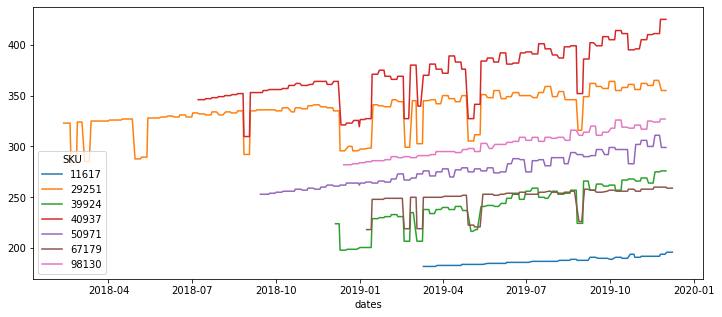

In [98]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=pivot_t[sku_show], dashes=False)

In [14]:
df[df.SKU == 11617].price_per_sku.unique()

array([182., 183., 184., 185., 186., 187., 188., 189., 191., 190., 194.,
       192., 196.])

## Классифицировать SKU на классы сезонностей
1. праздничных недель или недель со знаменательными событиями (например, 1 сентября)
1. летних недель
1. предновогодних недель (конец ноября — декабрь)

In [114]:
l = [
    [39924, 67179, 29251, 40937],
    [97818, 67286, ],
    [75536]
]
non_seasonal_sku = sorted(set(df.SKU.values) - {x for row in l for x in row})
non_seasonal_sku

[11617, 50971, 98130]

In [110]:
fpath_out = "part1.txt"
# 3 rows with sku,sku,sku...
with open(fpath_out, 'w') as f:
    for row in l:
        f.write(f"{','.join(map(str, row))}\n")

In [111]:
!cat part1.txt

39924,67179,29251,40937
97818,67286
75536


In [112]:
!explorer.exe .

## Предсказание диапазонов цен для SKU по датам

In [30]:
from prophet import Prophet

for sku in df.SKU.unique():
    print('SKU: ',sku)
    prophet = Prophet()
    train_data = df[df.SKU ==sku].reset_index(drop=True)
    train_data.price_per_sku = train_data.price_per_sku.ffill()
    prophet.fit(train_data[['dates', 'price_per_sku']].rename(columns={'dates':'ds','price_per_sku':'y'}))
    pred_df = prophet.predict(dftest[dftest.SKU ==sku][['dates']].rename(columns={'dates':'ds'}))
    pred_df.to_csv('prophet_predictions_{}.csv'.format(sku), index=None)

SKU:  11617


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  29251


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  39924


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  40937


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  50971


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  67179


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  67286


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  75536


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  97818


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU:  98130


In [52]:
!ls

competitors_based_price.ipynb  prophet_predictions_39924.csv
dynamic_classic_price.ipynb    prophet_predictions_40937.csv
factor_base_price.ipynb        prophet_predictions_50971.csv
hw2.ipynb		       prophet_predictions_67179.csv
hw4.ipynb		       prophet_predictions_67286.csv
hw6.ipynb		       prophet_predictions_75536.csv
part1.txt		       prophet_predictions_97818.csv
prophet_predictions_11617.csv  prophet_predictions_98130.csv
prophet_predictions_29251.csv


In [ ]:
non_seasonal_sku

In [195]:
dfpr = pd.DataFrame()
for sku in df.SKU.unique():
    if sku in non_seasonal_sku:
        continue
    dfcur = pd.read_csv('./prophet_predictions_{}.csv'.format(sku))
    dfcur['SKU'] = sku
    dfcur = dfcur[['ds','SKU', 'yhat_lower', 'yhat_upper']].rename(
        columns={
            'yhat_lower':'predicted_lower_bound'
            ,'yhat_upper':'predicted_upper_bound'
            , 'ds':'dates'
        })
    dfpr = pd.concat([dfcur,dfpr])
dfpr.head(2)

,dates,SKU,predicted_lower_bound,predicted_upper_bound
0,2019-12-02,97818,260.654132,290.011202
1,2019-12-12,97818,269.624802,297.769024


In [196]:
dfpr.dates = pd.to_datetime(dfpr.dates)

#### ARIMA

In [181]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

In [182]:
dfar = pd.DataFrame()
for sku in tqdm(df.SKU.unique()):
    if sku in non_seasonal_sku:
        continue
    # Autoregressive Integrated Moving Average
    dftrain = df[df.SKU == sku]
    ARIMA_ = ARIMA(dftrain.price_per_sku.values, order=(20,1,20))
    ARIMA_model = ARIMA_.fit()
    
    dfcur = dftest[dftest.SKU == sku]
    pred_count = dfcur.shape[0]
    dfcur['predicted_lower_bound'] = ARIMA_model.get_forecast(pred_count).conf_int(0.05)[:,0]
    dfcur['predicted_upper_bound'] = ARIMA_model.get_forecast(pred_count).conf_int(0.05)[:,1]
    
    dfar = pd.concat([dfcur,dfar], ignore_index=True)

dfar.head(2)

  0%|          | 0/10 [00:00<?, ?it/s]/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/nur/projects/analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/nur/projects/analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

,SKU,dates,predicted_lower_bound,predicted_upper_bound
0,97818,2019-12-02,246.784707,266.158704
1,97818,2019-12-12,242.076710,269.570905


In [183]:
dfar.dates = pd.to_datetime(dfar.dates)

#### Final result

In [199]:
assert dfar.shape[0] == dfpr.shape[0]

In [200]:
dfres = dfpred.merge(dfar, how='left', on=['SKU', 'dates'])
dfres

,dates,SKU,predicted_lower_bound_x,predicted_upper_bound_x,predicted_lower_bound_y,predicted_upper_bound_y
0,2019-12-02,97818,260.654132,290.011202,246.784707,266.158704
1,2019-12-12,97818,269.624802,297.769024,242.076710,269.570905
2,2019-12-17,97818,269.292021,298.378727,238.855682,272.633558
3,2019-12-23,97818,273.553069,302.320712,237.133409,276.108125
4,2019-12-03,75536,353.211190,371.790786,373.555700,386.893153
5,2019-12-10,75536,354.690895,374.061278,371.112222,390.295407
6,2019-12-16,75536,355.296037,375.766025,368.438167,391.947662
7,2019-12-23,75536,358.611266,377.859851,363.593081,391.201071
8,2019-11-11,67286,181.289618,199.399373,172.151344,183.944099
9,2019-11-18,67286,184.104644,202.515730,170.693459,187.408928


In [205]:
dfres['predicted_lower_bound'] = dfres[['predicted_lower_bound_x', 'predicted_lower_bound_y']].mean(axis=1)
dfres['predicted_upper_bound'] = dfres[['predicted_upper_bound_x', 'predicted_upper_bound_y']].mean(axis=1)

In [206]:
dfres = dftest.merge(dfres[['dates', 'SKU', 'predicted_lower_bound', 'predicted_upper_bound']], how='left', on=['SKU', 'dates'])

In [207]:
for sku in non_seasonal_sku:
    vals = df[df.SKU == sku].price_per_sku.values
    dfres.loc[dfres.SKU == sku,'predicted_lower_bound']= vals[-3:].min()
    dfres.loc[dfres.SKU == sku,'predicted_upper_bound']= vals.max()+4

In [208]:
fpath_out = "part2.csv"
# expected IoU>0.25
dfres[['SKU', 'dates', 'predicted_lower_bound', 'predicted_upper_bound']].to_csv(fpath_out, index=None)

In [209]:
!cat part2.csv

SKU,dates,predicted_lower_bound,predicted_upper_bound
11617,2019-12-11,196.0,200.0
11617,2019-12-16,196.0,200.0
11617,2019-12-23,196.0,200.0
11617,2019-12-30,196.0,200.0
29251,2019-12-02,344.10869459301097,376.587974842112
29251,2019-12-09,340.08632868172185,378.3274364367415
29251,2019-12-17,338.82275059274434,380.7308066190112
29251,2019-12-23,338.08259482399944,381.3854606426373
39924,2019-12-02,262.8980558888632,285.23128043815484
39924,2019-12-09,259.69898009249414,286.59369529436515
39924,2019-12-16,257.8992419494993,287.1688054742784
39924,2019-12-24,257.2804764828152,288.84037128068053
40937,2019-12-02,403.15667016423447,435.4444015340955
40937,2019-12-09,400.5260071578516,439.3507554443717
40937,2019-12-16,398.1157844436366,441.04444737258723
40937,2019-12-23,396.9826778518416,443.184378352036
50971,2019-12-02,299.0,315.0
50971,2019-12-09,299.0,315.0
50971,2019-12-16,299.0,315.0
50971,2019-12-23,299.0,315.0
67179,2019-12-09,246.75593051239446,269.400732131388
67179,2019-12-16,

In [210]:
!explorer.exe .